In [1]:
from deap import base, creator, tools, algorithms
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [2]:
class NurseSchedulingProblem:
    """This class encapsulates the Nurse Scheduling problem
    """

    def __init__(self, hardConstraintPenalty):
        """
        :param hardConstraintPenalty: the penalty factor for a hard-constraint violation
        """
        self.hardConstraintPenalty = hardConstraintPenalty

        # list of nurses:
        self.nurses = ['Debra', 'Riann', 'Velia', 'Synne', 'Anona', 'Noell', 'Fadwa', 'Zyana']

        # nurses' respective shift preferences - morning, evening, night:
        self.shiftPreference = [[1, 0, 0], [1, 1, 0], [0, 0, 1], [0, 1, 0], [0, 0, 1], [1, 1, 1], [0, 1, 1], [1, 1, 1]]

        # min and max number of nurses allowed for each shift - morning, evening, night:
        self.shiftMin = [2, 2, 1]
        self.shiftMax = [3, 4, 2]

        # max shifts per week allowed for each nurse
        self.maxShiftsPerWeek = 5

        # number of weeks we create a schedule for:
        self.weeks = 1

        # useful values:
        self.shiftPerDay = len(self.shiftMin)
        self.shiftsPerWeek = 7 * self.shiftPerDay

    def __len__(self):
        """
        :return: the number of shifts in the schedule
        """
        return len(self.nurses) * self.shiftsPerWeek * self.weeks


    def getCost(self, schedule):
        """
        Calculates the total cost of the various violations in the given schedule
        ...
        :param schedule: a list of binary values describing the given schedule
        :return: the calculated cost
        """

        if len(schedule) != self.__len__():
            raise ValueError("size of schedule list should be equal to ", self.__len__())

        # convert entire schedule into a dictionary with a separate schedule for each nurse:
        nurseShiftsDict = self.getNurseShifts(schedule)

        # count the various violations:
        consecutiveShiftViolations = self.countConsecutiveShiftViolations(nurseShiftsDict)
        shiftsPerWeekViolations = self.countShiftsPerWeekViolations(nurseShiftsDict)[1]
        nursesPerShiftViolations = self.countNursesPerShiftViolations(nurseShiftsDict)[1]
        shiftPreferenceViolations = self.countShiftPreferenceViolations(nurseShiftsDict)

        # calculate the cost of the violations:
        hardContstraintViolations = consecutiveShiftViolations + nursesPerShiftViolations + shiftsPerWeekViolations
        softContstraintViolations = shiftPreferenceViolations

        return self.hardConstraintPenalty * hardContstraintViolations + softContstraintViolations

    def getNurseShifts(self, schedule):
        """
        Converts the entire schedule into a dictionary with a separate schedule for each nurse
        :param schedule: a list of binary values describing the given schedule
        :return: a dictionary with each nurse as a key and the corresponding shifts as the value
        """
        shiftsPerNurse = self.__len__() // len(self.nurses)
        nurseShiftsDict = {}
        shiftIndex = 0

        for nurse in self.nurses:
            nurseShiftsDict[nurse] = schedule[shiftIndex:shiftIndex + shiftsPerNurse]
            shiftIndex += shiftsPerNurse

        return nurseShiftsDict

    def countConsecutiveShiftViolations(self, nurseShiftsDict):
        """
        Counts the consecutive shift violations in the schedule
        :param nurseShiftsDict: a dictionary with a separate schedule for each nurse
        :return: count of violations found
        """
        violations = 0
        # iterate over the shifts of each nurse:
        for nurseShifts in nurseShiftsDict.values():
            # look for two cosecutive '1's:
            for shift1, shift2 in zip(nurseShifts, nurseShifts[1:]):
                if shift1 == 1 and shift2 == 1:
                    violations += 1
        return violations

    def countShiftsPerWeekViolations(self, nurseShiftsDict):
        """
        Counts the max-shifts-per-week violations in the schedule
        :param nurseShiftsDict: a dictionary with a separate schedule for each nurse
        :return: count of violations found
        """
        violations = 0
        weeklyShiftsList = []
        # iterate over the shifts of each nurse:
        for nurseShifts in nurseShiftsDict.values():  # all shifts of a single nurse
            # iterate over the shifts of each weeks:
            for i in range(0, self.weeks * self.shiftsPerWeek, self.shiftsPerWeek):
                # count all the '1's over the week:
                weeklyShifts = sum(nurseShifts[i:i + self.shiftsPerWeek])
                weeklyShiftsList.append(weeklyShifts)
                if weeklyShifts > self.maxShiftsPerWeek:
                    violations += weeklyShifts - self.maxShiftsPerWeek

        return weeklyShiftsList, violations

    def countNursesPerShiftViolations(self, nurseShiftsDict):
        """
        Counts the number-of-nurses-per-shift violations in the schedule
        :param nurseShiftsDict: a dictionary with a separate schedule for each nurse
        :return: count of violations found
        """
        # sum the shifts over all nurses:
        totalPerShiftList = [sum(shift) for shift in zip(*nurseShiftsDict.values())]

        violations = 0
        # iterate over all shifts and count violations:
        for shiftIndex, numOfNurses in enumerate(totalPerShiftList):
            dailyShiftIndex = shiftIndex % self.shiftPerDay  # -> 0, 1, or 2 for the 3 shifts per day
            if (numOfNurses > self.shiftMax[dailyShiftIndex]):
                violations += numOfNurses - self.shiftMax[dailyShiftIndex]
            elif (numOfNurses < self.shiftMin[dailyShiftIndex]):
                violations += self.shiftMin[dailyShiftIndex] - numOfNurses

        return totalPerShiftList, violations

    def countShiftPreferenceViolations(self, nurseShiftsDict):
        """
        Counts the nurse-preferences violations in the schedule
        :param nurseShiftsDict: a dictionary with a separate schedule for each nurse
        :return: count of violations found
        """
        violations = 0
        for nurseIndex, shiftPreference in enumerate(self.shiftPreference):
            # duplicate the shift-preference over the days of the period
            preference = shiftPreference * (self.shiftsPerWeek // self.shiftPerDay)
            # iterate over the shifts and compare to preferences:
            shifts = nurseShiftsDict[self.nurses[nurseIndex]]
            for pref, shift in zip(preference, shifts):
                if pref == 0 and shift == 1:
                    violations += 1

        return violations

    def printScheduleInfo(self, schedule):
        """
        Prints the schedule and violations details
        :param schedule: a list of binary values describing the given schedule
        """
        nurseShiftsDict = self.getNurseShifts(schedule)
        weeklyShiftsList, violations = self.countShiftsPerWeekViolations(nurseShiftsDict)
        totalPerShiftList, violations = self.countNursesPerShiftViolations(nurseShiftsDict)
        shiftPreferenceViolations = self.countShiftPreferenceViolations(nurseShiftsDict)


        print("\n-- Violations:")
        print("consecutive shift violations = ", self.countConsecutiveShiftViolations(nurseShiftsDict))
        print("Shifts Per Week Violations = ", violations)
        print("Nurses Per Shift Violations = ", violations)
        print("Shift Preference Violations = ", shiftPreferenceViolations)


        print("\n-- Schedule for each nurse:")
        import pandas as pd
        column_names = pd.DataFrame(
            [
                ["Monday", "morning"], 
                ["Monday", "evening"], 
                ["Monday", "night"], 
        
                ["Tuesday", "morning"], 
                ["Tuesday", "evening"], 
                ["Tuesday", "night"],
        
                ["Wednesday", "morning"], 
                ["Wednesday", "evening"], 
                ["Wednesday", "night"],
        
                ["Thursday", "morning"], 
                ["Thursday", "evening"], 
                ["Thursday", "night"],
        
                ["Friday", "morning"], 
                ["Friday", "evening"], 
                ["Friday", "night"],
        
                ["Saturday", "morning"], 
                ["Saturday", "evening"], 
                ["Saturday", "night"],
        
                ["Sunday", "morning"], 
                ["Sunday", "evening"], 
                ["Sunday", "night"]
            ], 
            columns=["Nurse", ""]
        )
        rows = []
        nurses = []
        for nurse in nurseShiftsDict:
            rows.append(nurseShiftsDict[nurse])

        columns = pd.MultiIndex.from_frame(column_names)
        for nurse in nurseShiftsDict:
            nurses.append(nurse)

        pd.set_option('display.max_columns', None)
        df = pd.DataFrame(rows, columns=columns, index=nurses)
        
        df.loc['Nurses Per Shift']= df.sum()
        df["weekly Shifts"] = df.sum(axis=1)

        display(df)
    

In [3]:
def eaSimpleWithElitism(population, toolbox, cxpb, mutpb, ngen, stats=None,
             halloffame=None, verbose=__debug__):
    """This algorithm is similar to DEAP eaSimple() algorithm, with the modification that
    halloffame is used to implement an elitism mechanism. The individuals contained in the
    halloffame are directly injected into the next generation and are not subject to the
    genetic operators of selection, crossover and mutation.
    """
    logbook = tools.Logbook()
    logbook.header = ['gen', 'nevals'] + (stats.fields if stats else [])

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    if halloffame is None:
        raise ValueError("halloffame parameter must not be empty!")

    halloffame.update(population)
    hof_size = len(halloffame.items) if halloffame.items else 0

    record = stats.compile(population) if stats else {}
    logbook.record(gen=0, nevals=len(invalid_ind), **record)
    if verbose:
        print(logbook.stream)

    # Begin the generational process
    for gen in range(1, ngen + 1):

        # Select the next generation individuals
        offspring = toolbox.select(population, len(population) - hof_size)

        # Vary the pool of individuals
        offspring = algorithms.varAnd(offspring, toolbox, cxpb, mutpb)

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # add the best back to population:
        offspring.extend(halloffame.items)

        # Update the hall of fame with the generated individuals
        halloffame.update(offspring)

        # Replace the current population by the offspring
        population[:] = offspring

        # Append the current generation statistics to the logbook
        record = stats.compile(population) if stats else {}
        logbook.record(gen=gen, nevals=len(invalid_ind), **record)
        if verbose:
            print(logbook.stream)

    return population, logbook

In [4]:
# problem constants:
HARD_CONSTRAINT_PENALTY = 10  # the penalty factor for a hard-constraint violation

# set the random seed:
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

toolbox = base.Toolbox()

# create the nurse scheduling problem instance to be used:
nsp = NurseSchedulingProblem(HARD_CONSTRAINT_PENALTY)

# define a single objective, maximizing fitness strategy:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))

# create the Individual class based on list:
creator.create("Individual", list, fitness=creator.FitnessMin)

# create an operator that randomly returns 0 or 1:
toolbox.register("zeroOrOne", random.randint, 0, 1)

# create the individual operator to fill up an Individual instance:
toolbox.register("individualCreator", tools.initRepeat, creator.Individual, toolbox.zeroOrOne, len(nsp))

# create the population operator to generate a list of individuals:
toolbox.register("populationCreator", tools.initRepeat, list, toolbox.individualCreator)

In [5]:
# fitness calculation
def getCost(individual):
    return nsp.getCost(individual),  # return a tuple


toolbox.register("evaluate", getCost)

# genetic operators:
toolbox.register("select", tools.selTournament, tournsize=2)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=1.0/len(nsp))

In [6]:
# Genetic Algorithm flow:
def main(POPULATION_SIZE, MAX_GENERATIONS):

    # create initial population (generation 0):
    population = toolbox.populationCreator(n=POPULATION_SIZE)

    # prepare the statistics object:
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min)
    stats.register("avg", np.mean)

    # define the hall-of-fame object:
    hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

    # perform the Genetic Algorithm flow with hof feature added:
    population, logbook = eaSimpleWithElitism(
        population, 
        toolbox, 
        cxpb=P_CROSSOVER, 
        mutpb=P_MUTATION,
        ngen=MAX_GENERATIONS, 
        stats=stats, 
        halloffame=hof, 
        verbose=True
    )

    # print best solution found:
    best = hof.items[0]
    print("\n-- Best Individual = ", best)
    print("-- Best Fitness = ", best.fitness.values[0])
   
    #print("\n-- Schedule = ")
    nsp.printScheduleInfo(best)
    print()

    # extract statistics:
    minFitnessValues, meanFitnessValues = logbook.select("min", "avg")

    
    # plot statistics:
    sns.set(rc = {'figure.figsize':(20,10)})
    sns.set_style("whitegrid")
    plt.plot(minFitnessValues, color='red')
    plt.plot(meanFitnessValues, color='green')
    plt.xlabel('Generation')
    plt.ylabel('Min & Average Fitness')
    plt.title('Min & Average fitness over Generations')
    
    legend_drawn_flag = True
    plt.legend(["minFitnessValues", "meanFitnessValues"], loc=0, frameon=legend_drawn_flag)
    plt.text(0, 6,
          f'\
            Population size: {POPULATION_SIZE}\n\
            Number of generations: {MAX_GENERATIONS}\n\
            Crossover: {P_CROSSOVER}\n\
            Mutation: {P_MUTATION}',
            fontsize=15

    )

    plt.show()
    

gen	nevals	min	avg    
0  	100   	689	1150.19
1  	60    	689	997.14 
2  	68    	635	909.21 
3  	62    	490	831.09 
4  	61    	490	745.77 
5  	60    	434	684.83 
6  	64    	414	601.27 
7  	62    	324	541.73 
8  	63    	324	503.12 
9  	66    	324	468.78 
10 	60    	279	435.89 
11 	65    	279	400.24 
12 	68    	268	366    
13 	66    	187	339.51 
14 	67    	187	309.85 
15 	60    	187	285.31 
16 	59    	177	259.55 
17 	67    	176	241.45 
18 	62    	167	216.76 
19 	65    	167	197.97 
20 	68    	157	185.77 
21 	70    	147	174.56 
22 	67    	137	166.28 
23 	65    	127	157.03 
24 	59    	127	148.47 
25 	68    	117	144.19 
26 	67    	116	140.13 
27 	63    	116	134.87 
28 	68    	116	130.49 
29 	66    	106	126.2  
30 	61    	106	123.73 
31 	61    	106	118.43 
32 	64    	77 	114.82 
33 	65    	66 	112.22 
34 	58    	66 	109.18 
35 	65    	66 	103.75 
36 	61    	66 	97.91  
37 	69    	66 	90.9   
38 	60    	66 	81.98  
39 	68    	66 	76.28  
40 	65    	56 	72.6   
41 	62    	56 	69.82  
42 	62    	

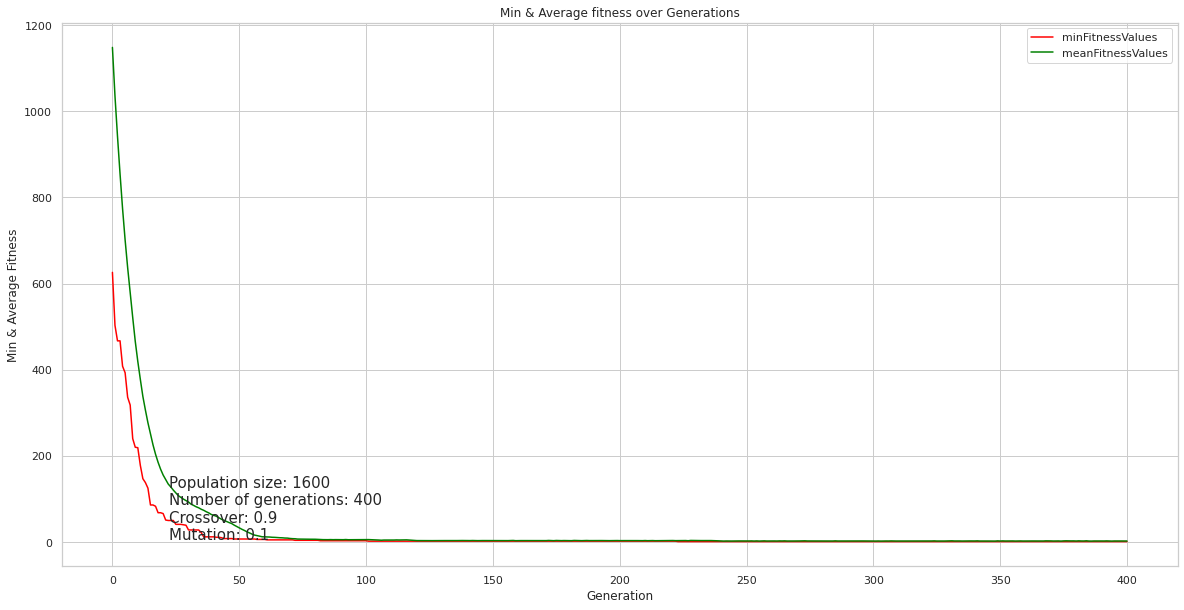

In [7]:
# Genetic Algorithm constants:
P_CROSSOVER = 0.9  # probability for crossover
P_MUTATION = 0.1   # probability for mutating an individual
HALL_OF_FAME_SIZE = 30
POPULATION_SIZE = [100, 300, 700, 1600]
MAX_GENERATIONS = [70, 150, 250, 400]


# main(POPULATION_SIZE, MAX_GENERATIONS)
for i in POPULATION_SIZE:
    for j in MAX_GENERATIONS:
        main(i, j)